In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from config.config import Config
from src.data_loader import DataLoader
from src.pre_processing import PreProcessor
from src.feature_extraction import FeatureExtractor
from src.cache_manager import CacheManager
from src.models import ModelFactory

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [11]:
config = Config()

FEATURE_SET = "baseline" # baseline / xgb
TEST_SIZE = 0.2
RANDOM_STATE = config.RANDOM_STATE
USE_DEFAULT_TRAIN_TEST_SPLIT = False
SELECTED_MODELS = ["xgboost"] # all for all models or select the models to train from models.py

In [3]:
loader = DataLoader()
preprocessor = PreProcessor()
feature_extractor = FeatureExtractor()
cache_manager = CacheManager()
factory = ModelFactory()
#cache_manager.clear_cache()
metadata = loader.load_metadata()

In [4]:
if USE_DEFAULT_TRAIN_TEST_SPLIT:
    train_df = metadata[metadata["fold"] != config.TEST_FOLD].copy()
    test_df  = metadata[metadata["fold"] == config.TEST_FOLD].copy()
else:
    train_df, test_df = train_test_split(
        metadata,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=metadata["classID"]
    )

print("\nTrain class distribution:")
print(train_df["classID"].value_counts().sort_index().to_string())

print("\nTest class distribution:")
print(test_df["classID"].value_counts().sort_index().to_string())


Train class distribution:
classID
0    800
1    343
2    800
3    800
4    800
5    800
6    299
7    800
8    743
9    800

Test class distribution:
classID
0    200
1     86
2    200
3    200
4    200
5    200
6     75
7    200
8    186
9    200


In [5]:
def extract_X_Y(df, feature_set):
    X, Y = [], []

    for _, row in df.iterrows():
        audio_path = loader.get_audio_path(row["slice_file_name"], row['fold'])

        feats = cache_manager.load_cached_features(audio_path, feature_set)
        if feats is None:
            audio, sr = preprocessor.load_and_preprocess(audio_path)
            feats = feature_extractor.extract_features(audio, sr)
            cache_manager.save_cached_features(audio_path, feature_set , feats)

        X.append(feats)
        Y.append(row["classID"])

    return np.array(X), np.array(Y)

In [6]:
X_train, Y_train = extract_X_Y(train_df, FEATURE_SET)
print("X_train:", X_train.shape, "y_train:", Y_train.shape)

X_test, Y_test = extract_X_Y(test_df, FEATURE_SET)
print("X_test:", X_test.shape, "y_test:", Y_test.shape)

print("\nFeature dimension:", X_train.shape[1])

X_train: (6985, 46) y_train: (6985,)
X_test: (1747, 46) y_test: (1747,)

Feature dimension: 46


In [7]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [12]:
all_models = factory.get_all_models()
results = {}

for model_name, model in all_models.items():
    if model_name == "all":
        continue
    elif model_name not in SELECTED_MODELS:
        continue

    print(f"TRAINING: {model_name}   (feature_set={FEATURE_SET})")
    model.fit(X_train_s, Y_train)
    Y_pred = model.predict(X_test_s)

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average="weighted", zero_division=0)
    rec = recall_score(Y_test, Y_pred, average="weighted", zero_division=0)
    f1 = f1_score(Y_test, Y_pred, average="weighted", zero_division=0)

    results[model_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

TRAINING: xgboost   (feature_set=baseline)
Accuracy : 0.9096
Precision: 0.9106
Recall   : 0.9096
F1-score : 0.9096


In [9]:
summary = pd.DataFrame(results).T.sort_values("accuracy", ascending=False)
summary

,accuracy,precision,recall,f1
xgboost,0.731183,0.747645,0.731183,0.727588
svm,0.729988,0.739693,0.729988,0.723555
gradient_boosting,0.715651,0.734281,0.715651,0.711644
random_forest,0.690562,0.714914,0.690562,0.688491
mlp,0.684588,0.686978,0.684588,0.678649
logistic_regression,0.637993,0.650093,0.637993,0.634534
knn,0.542413,0.640334,0.542413,0.533140


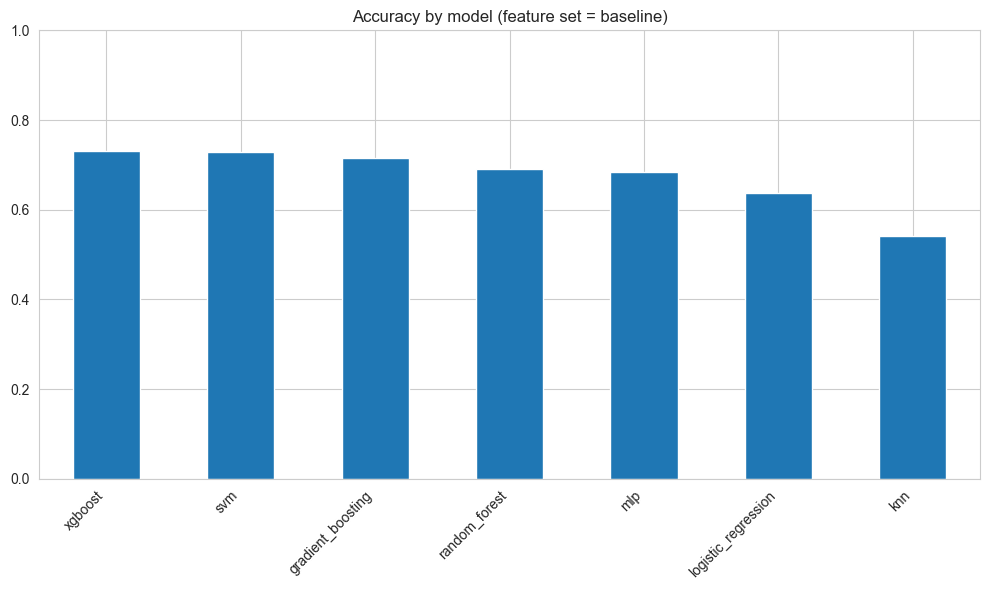

In [10]:
plt.figure(figsize=(10, 6))
summary["accuracy"].plot(kind="bar")
plt.title(f"Accuracy by model (feature set = {FEATURE_SET})")
plt.ylim(0,1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Best model: xgboost

Classification report:

                  precision    recall  f1-score   support

 air_conditioner       0.95      0.72      0.82       100
        car_horn       0.90      0.79      0.84        33
children_playing       0.65      0.81      0.72       100
        dog_bark       0.75      0.77      0.76       100
        drilling       0.53      0.84      0.65       100
   engine_idling       0.91      0.83      0.87        93
        gun_shot       0.84      1.00      0.91        32
      jackhammer       0.51      0.32      0.39        96
           siren       0.80      0.58      0.67        83
    street_music       0.82      0.84      0.83       100

        accuracy                           0.73       837
       macro avg       0.77      0.75      0.75       837
    weighted avg       0.75      0.73      0.73       837



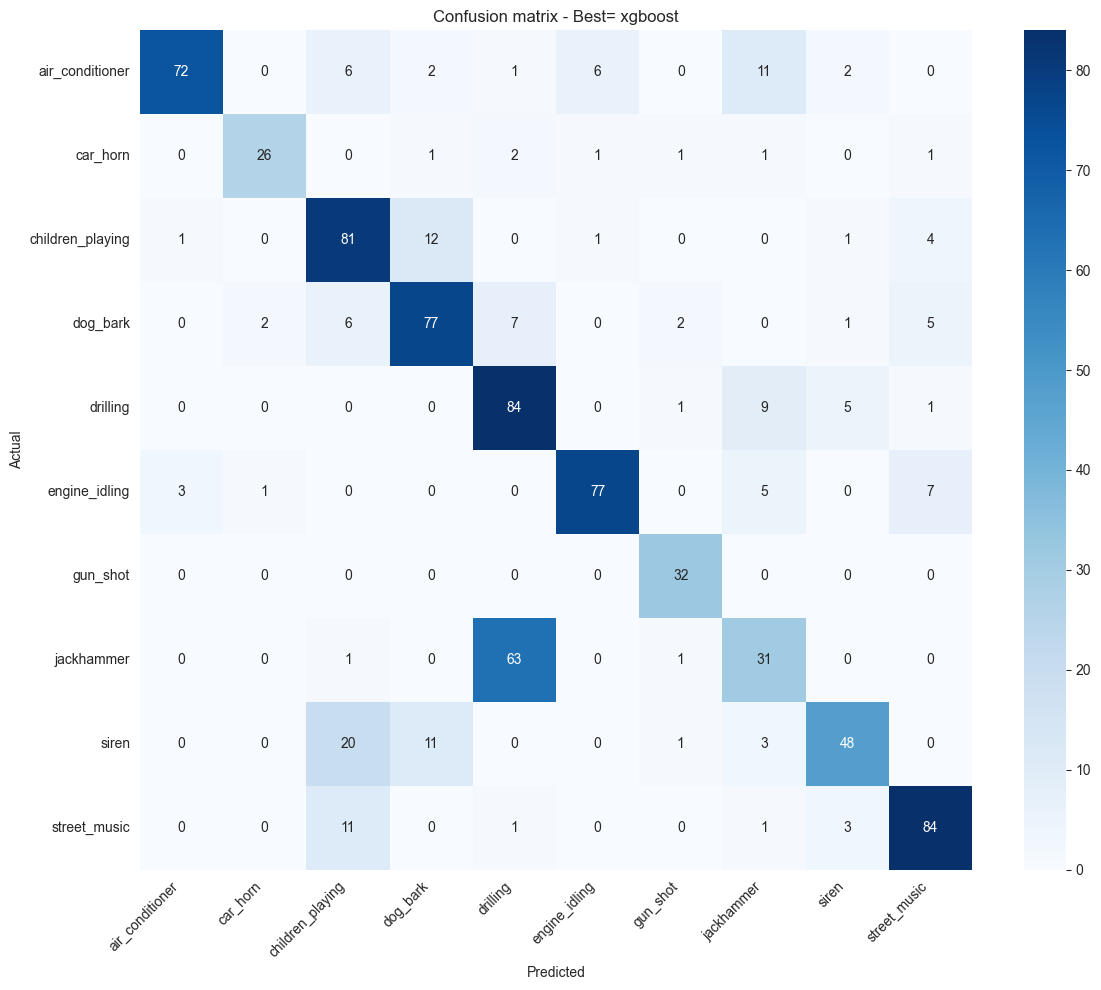

In [11]:
best_model_name = summary.index[0]
best_model = all_models[best_model_name]

print("Best model:", best_model_name)
best_model.fit(X_train_s, Y_train)
Y_pred_best = best_model.predict(X_test_s)

print("\nClassification report:\n")
print(classification_report(Y_test, Y_pred_best, target_names=config.CLASS_NAMES, zero_division=0))

cm = confusion_matrix(Y_test, Y_pred_best)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=config.CLASS_NAMES,
    yticklabels=config.CLASS_NAMES
)

plt.title(f"Confusion matrix - Best= {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [41]:
print("FEATURE_SET:", FEATURE_SET)
print("X_train shape:", X_train.shape)
print("First sample len:", len(X_train[0]))
print("Test folds:", sorted(test_df["fold"].unique()))

FEATURE_SET: xgb
X_train shape: (6985, 250)
First sample len: 250
Test folds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
